### Import necessary dependencies

In [151]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Defining modcrop function
- Make sure the image's width and height is completely divisible by the scale that we want to downsample the image to.

In [2]:
def modcrop(img, scale):
    h, w = img.shape[1], img.shape[2]  # img = torch.Size([3, H, W])
    h = h - (h % scale)
    w = w - (w % scale)
    img = img[:, :h, :w]
    return img

### Define preprocessing function and function to display the GT and LR version of an image
- Downsample each images in a folder and return a tuple containing the GT and input image

In [140]:
def convert_to_y_channel(image):
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y = ycbcr[:, :, 0]
    return y

In [141]:
def image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_channels, patch_height, patch_width = patch_size
    patches = []

    # Pad the image to ensure its dimensions are divisible by the patch size
    pad_height = patch_height - height % patch_height
    pad_width = patch_width - width % patch_width
    padded_image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)

    # Extract patches from the padded image
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)

    return patches

In [142]:
def preprocess_images_in_folder(folder_path, scale, patch_size):
    processed_images = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        input_image = cv2.imread(img_path)

        # Convert the image to Y channel
        GT_image_y = convert_to_y_channel(input_image)

        # Convert input image to tensor
        GT_tensor = torch.tensor(GT_image_y, dtype=torch.float32).unsqueeze(0) / 255.0  # Add channel dimension and normalize

        # Interpolate GT image to create LR image
        GT_image_y_pil = Image.fromarray(GT_image_y)  # Convert Y channel to PIL image for resizing
        LR_image = TF.resize(GT_image_y_pil, [GT_image_y_pil.size[1] // scale, GT_image_y_pil.size[0] // scale], interpolation=Image.BICUBIC)

        # Resize LR image to match the size of GT image
        LR_image_resized = TF.resize(LR_image, [GT_tensor.shape[1], GT_tensor.shape[2]], interpolation=Image.BICUBIC)
        LR_tensor_resized = TF.to_tensor(LR_image_resized).float()

        # Divide LR and GT images into patches
        LR_patches = image_to_patches(LR_tensor_resized, patch_size)
        GT_patches = image_to_patches(GT_tensor, patch_size)

        # Append LR and GT patches as a tuple
        processed_images.extend(zip(LR_patches, GT_patches))

    return processed_images


In [143]:
def display_image(LR, GT):
    
    # Display the label image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1, 2, 0))
    plt.title('Ground Truth (GT)')
    plt.axis('off')
    
    # Display the input image
    plt.subplot(1, 2, 2)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title('Low Resolution (LR)')
    plt.axis('off')

    plt.show()

### Preprocessing training images

In [145]:

train_folder_path = 'data/Train/ILSVRC2013'
test_set5_folder_path = 'data/Test/Set5/'
test_set14_folder_path = 'data/Test/Set14/'
scale = 3

processed_train_images = preprocess_images_in_folder(train_folder_path, scale, (1, 33,33))
processed_test_set5_images = preprocess_images_in_folder(test_set5_folder_path, scale, (1, 33,33))
processed_test_set14_images = preprocess_images_in_folder(test_set14_folder_path, scale, (1, 33, 33))

### Display random test images from Set5

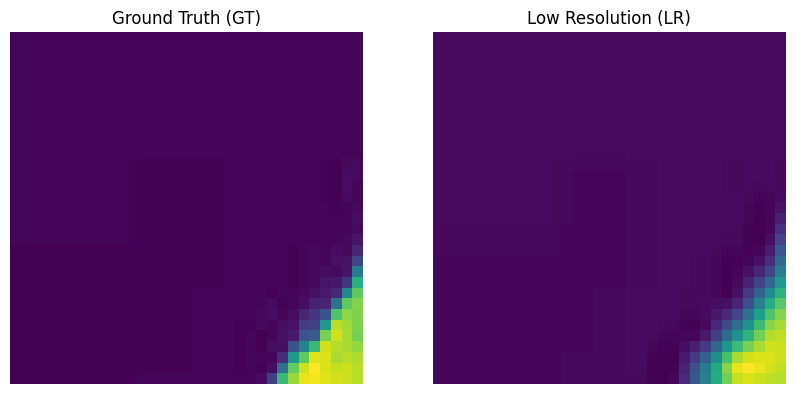

In [149]:
# Select a random image from the preprocessed images
random_image = random.choice(processed_test_set5_images)
LR, GT = random_image
# Display the random image
display_image(LR, GT)

### Putting preprocessed images in DataLoader

In [152]:
train_loader = DataLoader(processed_train_images, batch_size=128)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=128)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=128)

### Define SRCNN model architecture

In [153]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4)
        self.relu1 = nn.ReLU(True)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU(True)
        
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

### Settting up hyperparameters

In [154]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


In [155]:
model = SRCNN()
criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(),lr=0.0003)

num_epochs = 100
best_model_wts = None
best_loss = float('inf')

In [156]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for LR, GT in train_loader:
        LR, GT = LR.to(device), GT.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(LR)
        
        # Compute loss
        loss = criterion(outputs, GT)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * LR.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss}')
    
    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for LR, GT in test_set5_loader:
            LR, GT = LR.to(device), GT.to(device)
            outputs = model(LR)
            loss = criterion(outputs, GT)
            val_loss += loss.item() * LR.size(0)
    
    val_loss /= len(test_set5_loader.dataset)
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss Set 5: {val_loss}')
    
    # Save the best model weights
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = model.state_dict()

print('Training finished.')

# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), 'super_resolution_model_best.pth')

Epoch [10/100], Training Loss: 0.003352533316134558
Epoch [10/100], Validation Loss Set 5: 0.0009186513727565824
Epoch [20/100], Training Loss: 0.003052644218874108
Epoch [20/100], Validation Loss Set 5: 0.0008425715854033255
Epoch [30/100], Training Loss: 0.0029440026697233747
Epoch [30/100], Validation Loss Set 5: 0.0008155947275399789
Epoch [40/100], Training Loss: 0.0029252001373450296
Epoch [40/100], Validation Loss Set 5: 0.00080203453861077
Epoch [50/100], Training Loss: 0.0028974696164264313
Epoch [50/100], Validation Loss Set 5: 0.0007909745505256229
Epoch [60/100], Training Loss: 0.002877432174750592
Epoch [60/100], Validation Loss Set 5: 0.0007841271903925644
Epoch [70/100], Training Loss: 0.002860229078003365
Epoch [70/100], Validation Loss Set 5: 0.0007759659814632503
Epoch [80/100], Training Loss: 0.002849262888310457
Epoch [80/100], Validation Loss Set 5: 0.0007742489540757035
Epoch [90/100], Training Loss: 0.0028752269953514
Epoch [90/100], Validation Loss Set 5: 0.0007

### Training loop

### Test using validation sets

In [ ]:
# Evaluate model on validation set 5
model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(test_set5_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(test_set5_loader)
    print(f"Validation Loss for Set 5: {average_val_loss}")

In [ ]:
# Evaluate model on validation set 14
model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch_idx, (val_inputs, val_labels) in enumerate(test_set14_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        
        val_outputs = model(val_inputs)
        
        val_loss += criterion(val_outputs, val_labels).item()
    
    # Calculate average validation loss
    average_val_loss = val_loss / len(test_set14_loader)
    print(f"Validation Loss for Set 14: {average_val_loss}")

### Visualizing result

In [137]:
def extract_cb_cr(image):
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    cb = ycbcr[:, :, 1]
    cr = ycbcr[:, :, 2]
    return cb, cr

In [177]:
def process_and_save_image(input_image_path, output_image_path):
    input_image = cv2.imread(input_image_path)

    # Extract Cb and Cr channels
    input_image_Cb, input_image_Cr = extract_cb_cr(input_image)

    # Convert the image to Y channel
    input_image_Y = convert_to_y_channel(input_image)

    # Convert the Y channel to tensor
    input_tensor = torch.tensor(input_image_Y, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0  # Add channel and batch dimensions and normalize

    # Process image for GT (ground truth) and LR (low resolution)
    GT_tensor = input_tensor.to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        SR_tensor = model(GT_tensor)

    # Post-process SR tensor
    SR_tensor = SR_tensor.squeeze().cpu().numpy()  # Remove batch and channel dimensions and convert to NumPy
    SR_tensor = np.clip(SR_tensor * 255.0, 0, 255).astype(np.uint8)  # Rescale to 0-255 and convert to uint8

    # Combine SR Y channel with original Cb and Cr channels
    SR_ycbcr = cv2.merge((SR_tensor, input_image_Cb, input_image_Cr))
    SR_image = cv2.cvtColor(SR_ycbcr, cv2.COLOR_YCrCb2BGR)

    # Save the super-resolved image
    cv2.imwrite(output_image_path, SR_image)

# Directories
input_dirs = ['data/Test/Set5', 'data/Test/Set14']
output_dir = 'results'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process all images in the specified directories
image_paths = []
for input_dir in input_dirs:
    for filename in os.listdir(input_dir):
        if filename.endswith('.bmp'):
            input_image_path = os.path.join(input_dir, filename)
            base_name, ext = os.path.splitext(filename)
            output_image_name = f"{base_name.split('_')[0]}_SR{ext}"
            output_image_path = os.path.join(output_dir, output_image_name)

            process_and_save_image(input_image_path, output_image_path)
            image_paths.append((input_image_path, output_image_path))
            print(f"Processed and saved: {output_image_path}")


Processed and saved: results\baby_SR.bmp
Processed and saved: results\bird_SR.bmp
Processed and saved: results\butterfly_SR.bmp
Processed and saved: results\head_SR.bmp
Processed and saved: results\woman_SR.bmp
Processed and saved: results\baboon_SR.bmp
Processed and saved: results\barbara_SR.bmp
Processed and saved: results\bridge_SR.bmp
Processed and saved: results\coastguard_SR.bmp
Processed and saved: results\comic_SR.bmp
Processed and saved: results\face_SR.bmp
Processed and saved: results\flowers_SR.bmp
Processed and saved: results\foreman_SR.bmp
Processed and saved: results\lenna_SR.bmp
Processed and saved: results\man_SR.bmp
Processed and saved: results\monarch_SR.bmp
Processed and saved: results\pepper_SR.bmp
Processed and saved: results\ppt3_SR.bmp
Processed and saved: results\zebra_SR.bmp


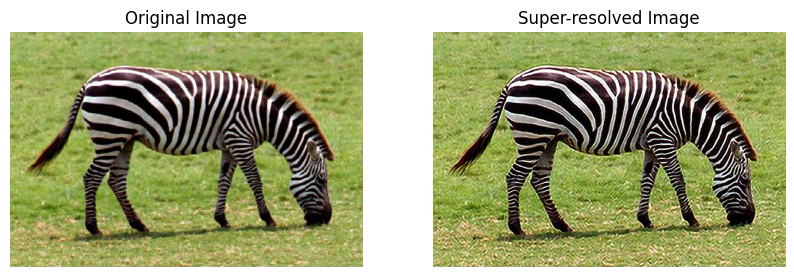

In [178]:
random_input_image_path, random_output_image_path = random.choice(image_paths)

# Load the original and super-resolved images
original_image = Image.open(random_input_image_path).convert('RGB')  # Load original image
super_resolved_image = Image.open(random_output_image_path).convert('RGB')  # Load super-resolved image

# Display the images side by side using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Super-resolved image
plt.subplot(1, 2, 2)
plt.imshow(super_resolved_image)
plt.title('Super-resolved Image')
plt.axis('off')

plt.show()